Num GPUs Available: 1
train dataset:
(27648, 8)
test dataset:
(2544, 8)
------------------------------------------------------------------------------------------
Stage 1 for CNN:
Epoch 1/1000
345/345 [==============================] - 2s 5ms/step - loss: 0.1918 - val_loss: 0.1748
Epoch 2/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1596 - val_loss: 0.1708
Epoch 3/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1546 - val_loss: 0.1685
Epoch 4/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1517 - val_loss: 0.1646
Epoch 5/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1497 - val_loss: 0.1695
Epoch 6/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1492 - val_loss: 0.1638
Epoch 7/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1459 - val_loss: 0.1690
Epoch 8/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1453 - val_loss: 0.1596
Epoc

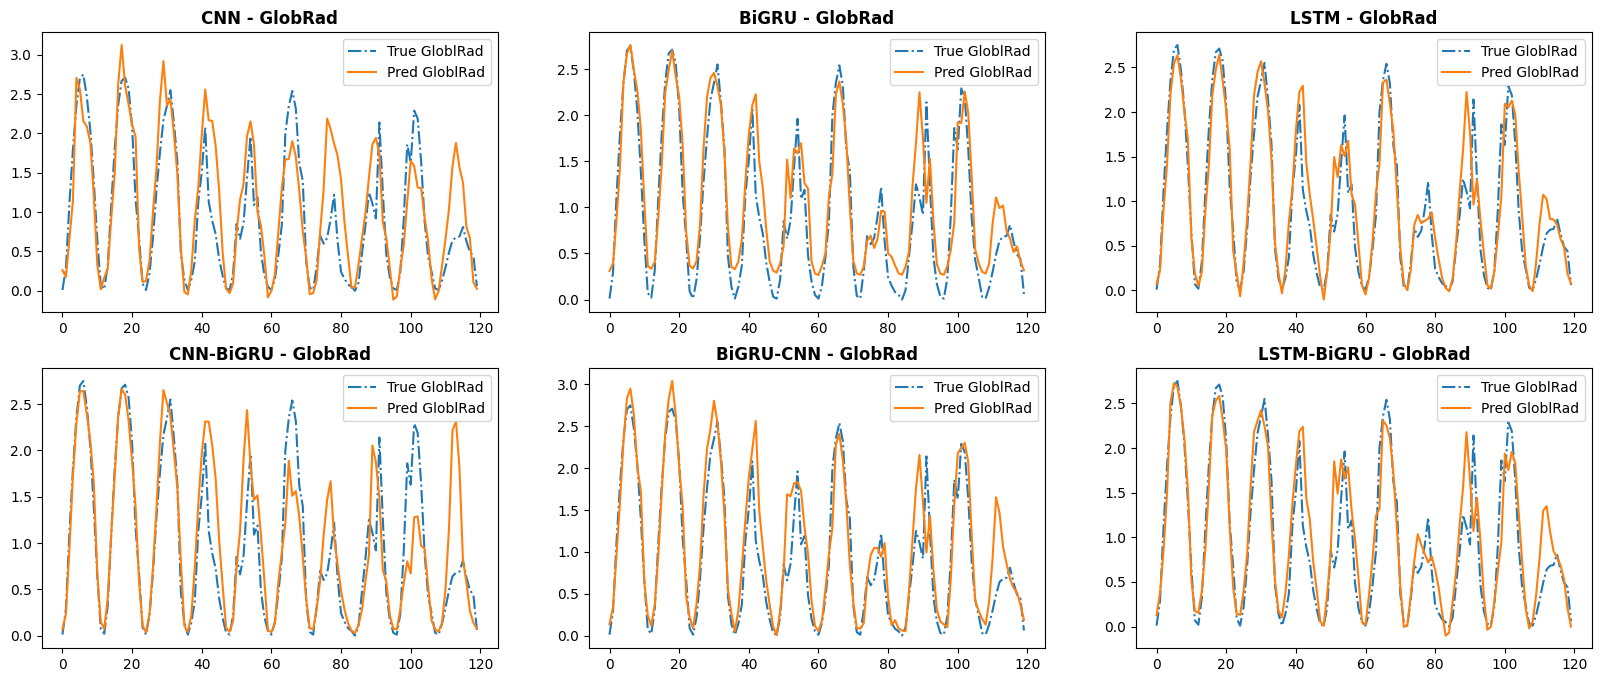

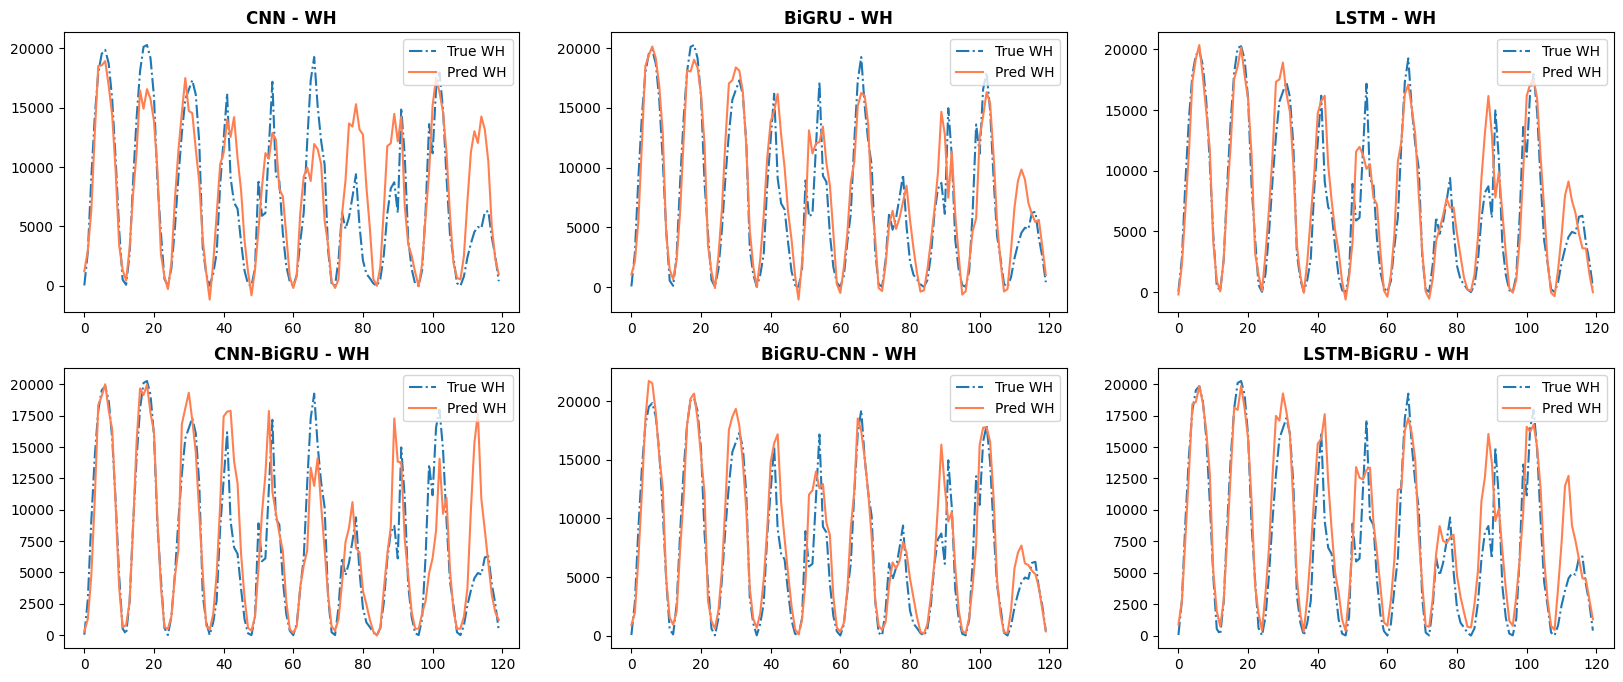

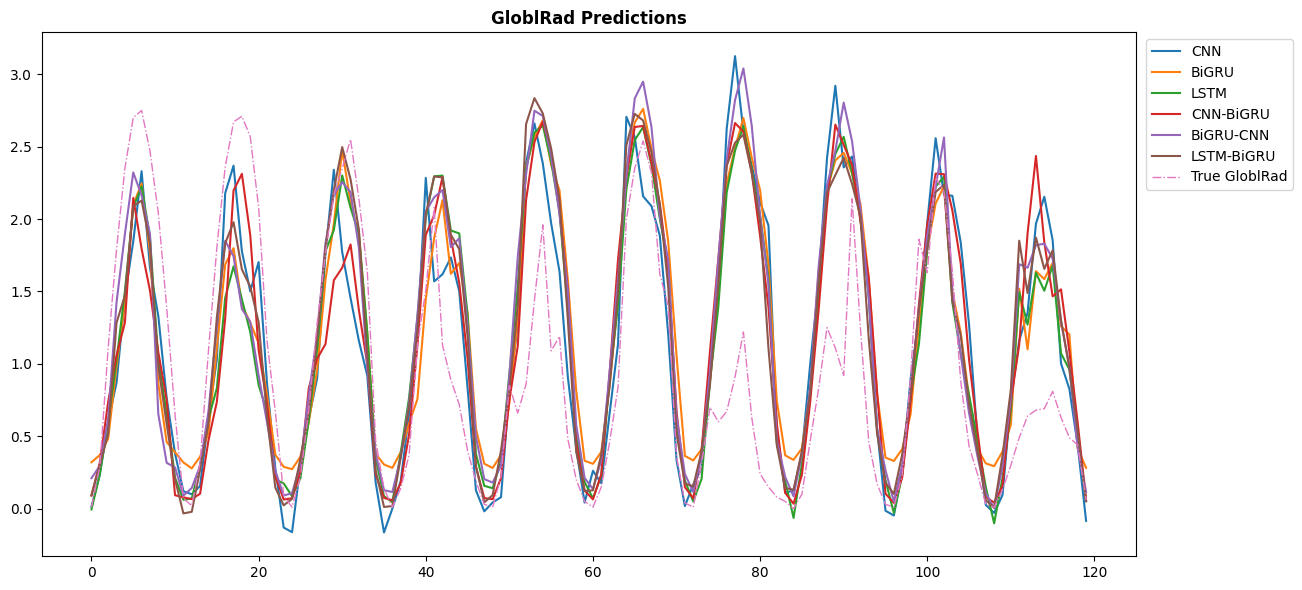

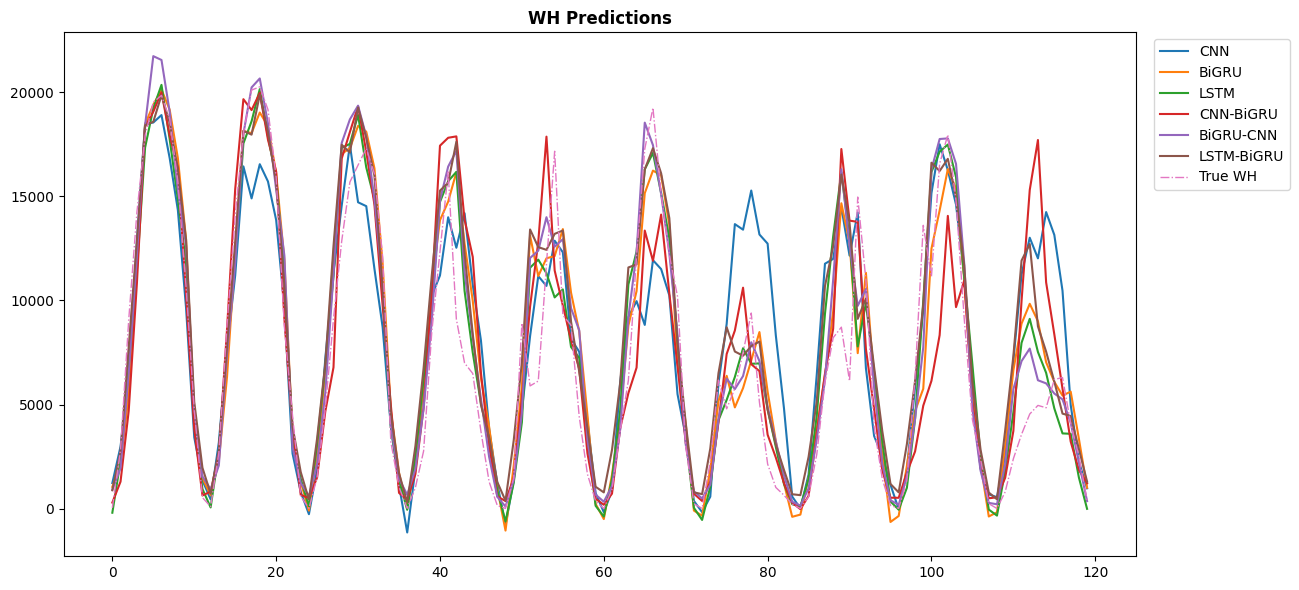

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import MultiHeadAttention
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import optuna

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train_val_data = pd.read_csv('train_dataset.csv', index_col='Time')
test_data = pd.read_csv('test_dataset.csv', index_col='Time')
test_data['WH'] = test_data['WH'].astype(float)
test_data['UVI'] = test_data['UVI'].astype(float)
train_val_data['WH_Lag12'] = train_val_data['WH'].shift(12)
train_val_data.dropna(inplace=True)
test_data['WH_Lag12'] = test_data['WH'].shift(12)
test_data.dropna(inplace=True)

features = ['WH', 'Temperature', 'RH', 'GloblRad', 'UVI', 'WH_Lag12']
scaler = MinMaxScaler()
train_val_data_scaled = scaler.fit_transform(train_val_data[features])
test_data_scaled = scaler.transform(test_data[features])
train_val_data[features] = train_val_data_scaled
test_data[features] = test_data_scaled

print("train dataset:")
print(train_val_data.shape)
print("test dataset:")
print(test_data.shape)

def inverse_transform_single_feature(scaler, data, feature_index):
    inverted_data = np.zeros((len(data), len(features)))
    inverted_data[:, feature_index] = data
    return scaler.inverse_transform(inverted_data)[:, feature_index]

def prepare_data_for_power_prediction(features, target, sequence_length, batch_size, train_ratio=0.8, val_ratio=0.2):
    num_samples = len(features) - sequence_length
    X = np.zeros((num_samples, sequence_length, features.shape[1]))
    y = np.zeros(num_samples)
    
    for i in range(num_samples):
        X[i] = features[i:i+sequence_length]
        y[i] = target[i+sequence_length]
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    val_size = int(val_ratio * num_samples)
    train_size = num_samples - val_size
    
    val_dataset = dataset.take(val_size).batch(batch_size)
    train_dataset = dataset.skip(val_size).shuffle(buffer_size=train_size).batch(batch_size)
    
    return train_dataset, val_dataset

def prepare_test_data(features, target, sequence_length, batch_size):
    num_samples = len(features) - sequence_length
    X_test = np.zeros((num_samples, sequence_length, features.shape[1]))
    y_test = np.zeros(num_samples)
    
    for i in range(num_samples):
        X_test[i] = features[i:i+sequence_length]
        y_test[i] = target[i+sequence_length]
    
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    
    return test_dataset

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        return attn_output

def rmse_(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def create_model(model_type, input_shape, units, dropout_rate, units2=None, units3=None, units4=None, units5=None):
    if units2 is None:
        units2 = units // 2
    if units3 is None:
        units3 = units2 // 2
    if units4 is None:
        units4 = units3 // 2
    if units5 is None:
        units5 = units4 // 2

    num_heads = 4
    key_dim = units // num_heads
    
    if model_type == 'CNN':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(filters=units2, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units3, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units4, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'BiGRU':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Bidirectional(layers.GRU(units2, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'LSTM':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.LSTM(units2, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units3, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units4, return_sequences=True),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'CNN-BiGRU':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(filters=units, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units2, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'BiGRU-CNN':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Bidirectional(layers.GRU(units, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units2, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Conv1D(filters=units3, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units4, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'LSTM-BiGRU': 
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.LSTM(units, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units2, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=rmse_)
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

results_stage1 = []
results_stage2 = []
predictions_stage1 = {}
predictions_stage2 = {}

# Stage 1: GloblRad
features_stage1 = ['Temperature', 'RH', 'UVI', 'Partly Cloudy', 'Sunny', 'WH_Lag12']
target_stage1 = 'GloblRad'
sequence_length = 60
batch_size = 64
epochs = 1000
models_list = ['CNN', 'BiGRU', 'LSTM', 'CNN-BiGRU', 'BiGRU-CNN', 'LSTM-BiGRU']

for model_type in models_list:
    print("-" * 90)
    print(f"Stage 1 for {model_type}:")

    train_dataset_stage1, val_dataset_stage1 = prepare_data_for_power_prediction(
        train_val_data[features_stage1].values, 
        train_val_data[target_stage1].values, 
        sequence_length=sequence_length,
        batch_size=batch_size
    )

    model_stage1 = create_model(model_type, input_shape=(sequence_length, len(features_stage1)), units=256, dropout_rate=0.2)
    model_stage1.fit(train_dataset_stage1, validation_data=val_dataset_stage1, epochs=epochs, verbose=1, callbacks=[early_stopping, reduce_lr])

    test_dataset_stage1 = prepare_test_data(
        test_data[features_stage1].values,
        test_data[target_stage1].values,
        sequence_length=sequence_length,
        batch_size=batch_size
    )

    num_samples_train = len(train_val_data) - sequence_length
    X_train = np.zeros((num_samples_train, sequence_length, len(features_stage1)))

    for i in range(num_samples_train):
        X_train[i] = train_val_data[features_stage1].values[i:i+sequence_length]
    
    predicted_train = model_stage1.predict(X_train).flatten()
    train_val_data[f'Predicted_GloblRad_{model_type}'] = np.nan
    train_val_data.iloc[sequence_length:, train_val_data.columns.get_loc(f'Predicted_GloblRad_{model_type}')] = predicted_train
    
    predicted_test = model_stage1.predict(test_dataset_stage1).flatten()
    test_data[f'Predicted_GloblRad_{model_type}'] = np.nan
    test_data.iloc[sequence_length:, test_data.columns.get_loc(f'Predicted_GloblRad_{model_type}')] = predicted_test
    
    mse = mean_squared_error(test_data[target_stage1].values[sequence_length:], predicted_test)
    mae = mean_absolute_error(test_data[target_stage1].values[sequence_length:], predicted_test)
    r2 = r2_score(test_data[target_stage1].values[sequence_length:], predicted_test)
    rmse = np.sqrt(mse)
    results_stage1.append([model_type, mse, mae, r2, rmse])
    predictions_stage1[model_type] = (test_data[target_stage1].values[sequence_length:], predicted_test)
    
train_val_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Stage 2: WH
features_stage2 = ['Temperature', 'RH', 'UVI', 'Partly Cloudy', 'Sunny', 'WH_Lag12'] + [f'Predicted_GloblRad_{model_type}']
target_stage2 = 'WH'

for model_type in models_list:
    print("-" * 90)
    print(f"Stage 2 training for {model_type}:")
    
    train_dataset_stage2, val_dataset_stage2 = prepare_data_for_power_prediction(
        train_val_data[features_stage2].values, 
        train_val_data[target_stage2].values, 
        sequence_length=sequence_length, 
        batch_size=batch_size
    )

    model_stage2 = create_model(model_type, input_shape=(sequence_length, len(features_stage2)), units=256, dropout_rate=0.2)
    model_stage2.fit(train_dataset_stage2, validation_data=val_dataset_stage2, epochs=epochs, verbose=1, callbacks=[early_stopping, reduce_lr])
    
    test_data_stage2 = prepare_test_data(
        test_data[features_stage2].values, 
        test_data[target_stage2].values, 
        sequence_length=sequence_length, 
        batch_size=batch_size
    )

    test_predictions = model_stage2.predict(test_data_stage2).flatten()

    mse = mean_squared_error(test_data[target_stage2].values[sequence_length:], test_predictions)
    mae = mean_absolute_error(test_data[target_stage2].values[sequence_length:], test_predictions)
    r2 = r2_score(test_data[target_stage2].values[sequence_length:], test_predictions)
    rmse = np.sqrt(mse)
    results_stage2.append([model_type, mse, mae, r2, rmse])
    predictions_stage2[model_type] = (test_data[target_stage2].values[sequence_length:], test_predictions)

##########
df_stage1 = pd.DataFrame(results_stage1, columns=['Model', 'MSE', 'MAE', 'R2', 'RMSE'])
print("-" * 55)
print("Stage 1 (GloblRad prediction) Results:")
print(df_stage1)

df_stage2 = pd.DataFrame(results_stage2, columns=['Model', 'MSE', 'MAE', 'R2', 'RMSE'])
print("-" * 55)
print("Stage 2 (WH prediction) Results:")
print(df_stage2)
print("-" * 55)

fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()

for idx, model_type in enumerate(models_list):
    true_globlrad = test_data['GloblRad'].values[sequence_length:]
    pred_globlrad = test_data[f'Predicted_GloblRad_{model_type}'].values[sequence_length:]

    true_globlrad_original = inverse_transform_single_feature(scaler, true_globlrad, features.index('GloblRad'))
    pred_globlrad_original = inverse_transform_single_feature(scaler, pred_globlrad, features.index('GloblRad'))

    axes[idx].plot(true_globlrad_original[240:360], label='True GloblRad', linestyle='-.')
    axes[idx].plot(pred_globlrad_original[240:360], label='Pred GloblRad')
    axes[idx].set_title(f'{model_type} - GlobRad', fontweight='bold')
    axes[idx].legend(loc='upper right')

fig_1, axes_1 = plt.subplots(2, 3, figsize=(20, 8))
axes_1 = axes_1.flatten()

for idx, model_type in enumerate(models_list):
    true_wh = test_data['WH'].values[sequence_length:]
    pred_wh = predictions_stage2[model_type][1]

    true_wh_original = inverse_transform_single_feature(scaler, true_wh, features.index('WH'))
    pred_wh_original = inverse_transform_single_feature(scaler, pred_wh, features.index('WH'))

    axes_1[idx].plot(true_wh_original[240:360], label='True WH', linestyle='-.')
    axes_1[idx].plot(pred_wh_original[240:360], label='Pred WH', color='coral')
    axes_1[idx].set_title(f'{model_type} - WH', fontweight='bold')
    axes_1[idx].legend(loc='upper right')

fig_globlrad, ax_globlrad = plt.subplots(figsize=(13, 6))
for model_type in models_list:
    true_globlrad, pred_globlrad = predictions_stage1[model_type]
    pred_globlrad_original = inverse_transform_single_feature(scaler, pred_globlrad, features.index('GloblRad'))
    ax_globlrad.plot(pred_globlrad_original[240:360], label=f'{model_type}')
ax_globlrad.plot(true_globlrad_original[240:360], label='True GloblRad', linestyle='-.', linewidth=1)
ax_globlrad.set_title('GloblRad Predictions', fontweight='bold')
ax_globlrad.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

fig_wh, ax_wh = plt.subplots(figsize=(13, 6))
for model_type in models_list:
    true_wh, pred_wh = predictions_stage2[model_type]
    pred_wh_original = inverse_transform_single_feature(scaler, pred_wh, features.index('WH'))
    ax_wh.plot(pred_wh_original[240:360], label=f'{model_type}')
ax_wh.plot(true_wh_original[240:360], label='True WH', linestyle='-.', linewidth=1)
ax_wh.set_title('WH Predictions', fontweight='bold')
ax_wh.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

plt.show()

Num GPUs Available: 1
train dataset:
(27648, 8)
test dataset:
(2544, 8)
------------------------------------------------------------------------------------------
Stage 1 for CNN:
Epoch 1/1000
345/345 [==============================] - 9s 5ms/step - loss: 0.2111 - val_loss: 0.1727
Epoch 2/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1635 - val_loss: 0.1693
Epoch 3/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1582 - val_loss: 0.1974
Epoch 4/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1534 - val_loss: 0.1668
Epoch 5/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1507 - val_loss: 0.1635
Epoch 6/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1482 - val_loss: 0.1660
Epoch 7/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1461 - val_loss: 0.1603
Epoch 8/1000
345/345 [==============================] - 1s 4ms/step - loss: 0.1449 - val_loss: 0.1672
Epoc

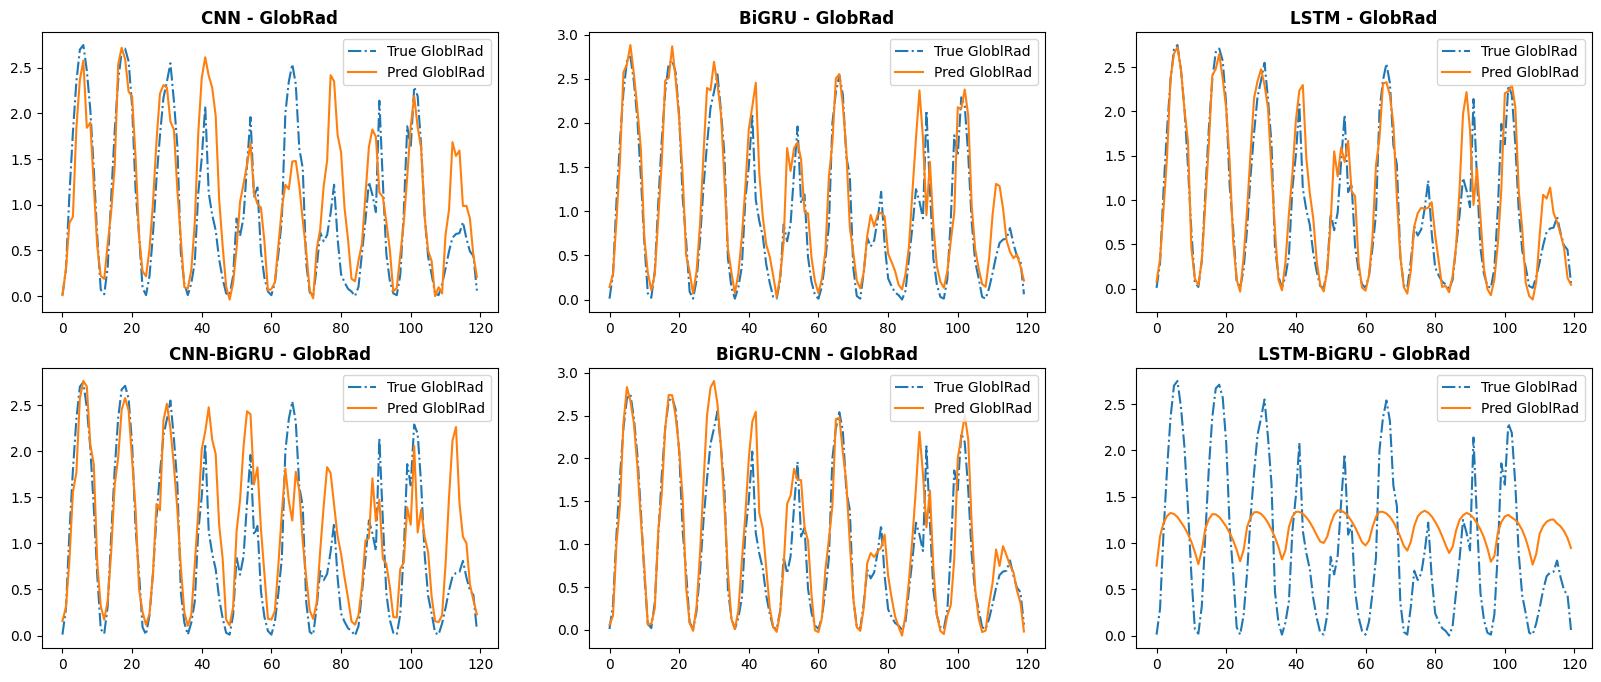

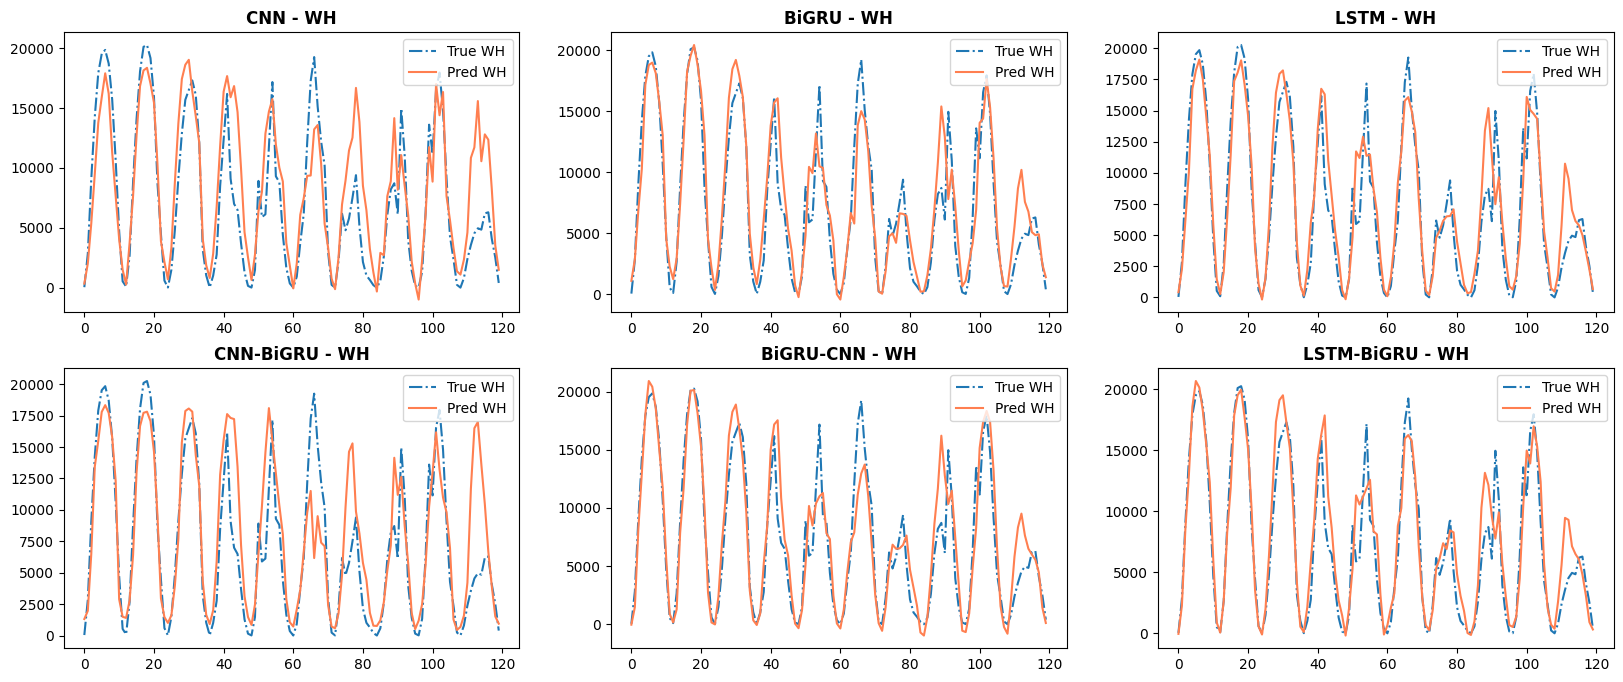

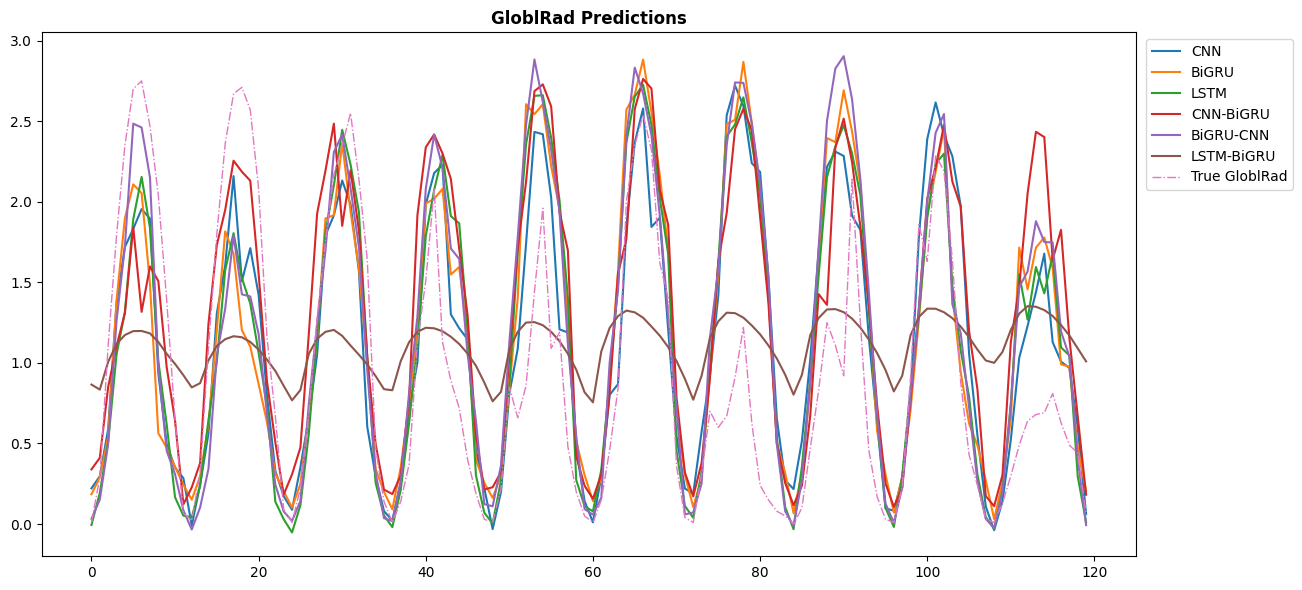

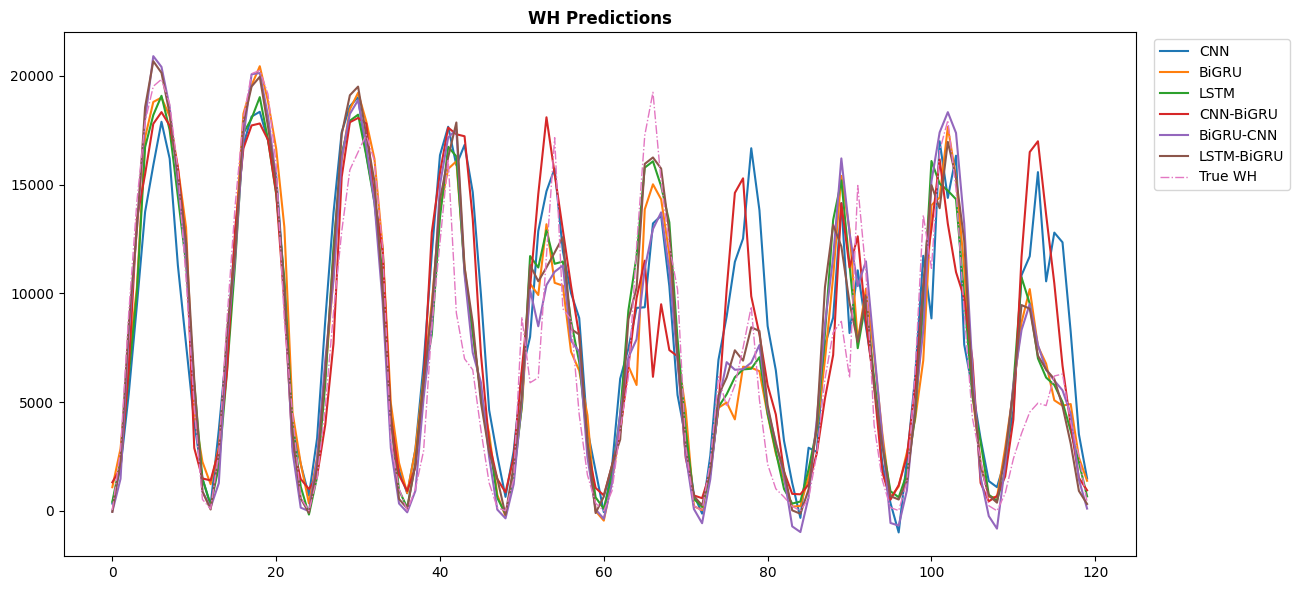

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import MultiHeadAttention
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import optuna

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

train_val_data = pd.read_csv('train_dataset.csv', index_col='Time')
test_data = pd.read_csv('test_dataset.csv', index_col='Time')
test_data['WH'] = test_data['WH'].astype(float)
test_data['UVI'] = test_data['UVI'].astype(float)
train_val_data['WH_Lag12'] = train_val_data['WH'].shift(12)
train_val_data.dropna(inplace=True)
test_data['WH_Lag12'] = test_data['WH'].shift(12)
test_data.dropna(inplace=True)

features = ['WH', 'Temperature', 'RH', 'GloblRad', 'UVI', 'WH_Lag12']
scaler = MinMaxScaler()
train_val_data_scaled = scaler.fit_transform(train_val_data[features])
test_data_scaled = scaler.transform(test_data[features])
train_val_data[features] = train_val_data_scaled
test_data[features] = test_data_scaled

print("train dataset:")
print(train_val_data.shape)
print("test dataset:")
print(test_data.shape)

def inverse_transform_single_feature(scaler, data, feature_index):
    inverted_data = np.zeros((len(data), len(features)))
    inverted_data[:, feature_index] = data
    return scaler.inverse_transform(inverted_data)[:, feature_index]

def prepare_data_for_power_prediction(features, target, sequence_length, batch_size, train_ratio=0.8, val_ratio=0.2):
    num_samples = len(features) - sequence_length
    X = np.zeros((num_samples, sequence_length, features.shape[1]))
    y = np.zeros(num_samples)
    
    for i in range(num_samples):
        X[i] = features[i:i+sequence_length]
        y[i] = target[i+sequence_length]
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    val_size = int(val_ratio * num_samples)
    train_size = num_samples - val_size
    
    val_dataset = dataset.take(val_size).batch(batch_size)
    train_dataset = dataset.skip(val_size).shuffle(buffer_size=train_size).batch(batch_size)
    
    return train_dataset, val_dataset

def prepare_test_data(features, target, sequence_length, batch_size):
    num_samples = len(features) - sequence_length
    X_test = np.zeros((num_samples, sequence_length, features.shape[1]))
    y_test = np.zeros(num_samples)
    
    for i in range(num_samples):
        X_test[i] = features[i:i+sequence_length]
        y_test[i] = target[i+sequence_length]
    
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)
    
    return test_dataset

class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(MultiHeadSelfAttention, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, x):
        attn_output = self.mha(query=x, key=x, value=x)
        return attn_output

def rmse_(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def create_model(model_type, input_shape, units, dropout_rate, units2=None, units3=None, units4=None, units5=None):
    if units2 is None:
        units2 = units // 2
    if units3 is None:
        units3 = units2 // 2
    if units4 is None:
        units4 = units3 // 2
    if units5 is None:
        units5 = units4 // 2

    num_heads = 4
    key_dim = units // num_heads
    
    if model_type == 'CNN':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(filters=units2, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units3, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units4, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'BiGRU':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Bidirectional(layers.GRU(units2, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'LSTM':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.LSTM(units2, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units3, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units4, return_sequences=True),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'CNN-BiGRU':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv1D(filters=units, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units2, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'BiGRU-CNN':
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.Bidirectional(layers.GRU(units, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units2, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Conv1D(filters=units3, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            layers.Conv1D(filters=units4, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
            layers.MaxPooling1D(pool_size=2, strides=2),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])
    elif model_type == 'LSTM-BiGRU': 
        model = models.Sequential([
            layers.Input(shape=input_shape),
            layers.LSTM(units, return_sequences=True),
            layers.Dropout(dropout_rate),
            layers.LSTM(units2, return_sequences=True),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Bidirectional(layers.GRU(units3, return_sequences=True)),
            layers.Dropout(dropout_rate),
            layers.Bidirectional(layers.GRU(units4, return_sequences=True)),
            layers.Dropout(dropout_rate),
            MultiHeadSelfAttention(num_heads=num_heads, key_dim=key_dim),
            layers.Flatten(),
            layers.Dense(units5, activation='relu'),
            layers.Dropout(dropout_rate),
            layers.Dense(1)
        ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=rmse_)
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-5
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

results_stage1 = []
results_stage2 = []
predictions_stage1 = {}
predictions_stage2 = {}

# Stage 1: GloblRad
features_stage1 = ['Temperature', 'RH', 'UVI', 'Partly Cloudy', 'Sunny', 'WH_Lag12']
target_stage1 = 'GloblRad'
sequence_length = 60
batch_size = 64
epochs = 1000
models_list = ['CNN', 'BiGRU', 'LSTM', 'CNN-BiGRU', 'BiGRU-CNN', 'LSTM-BiGRU']

for model_type in models_list:
    print("-" * 90)
    print(f"Stage 1 for {model_type}:")

    train_dataset_stage1, val_dataset_stage1 = prepare_data_for_power_prediction(
        train_val_data[features_stage1].values, 
        train_val_data[target_stage1].values, 
        sequence_length=sequence_length,
        batch_size=batch_size
    )

    model_stage1 = create_model(model_type, input_shape=(sequence_length, len(features_stage1)), units=256, dropout_rate=0.2)
    model_stage1.fit(train_dataset_stage1, validation_data=val_dataset_stage1, epochs=epochs, verbose=1, callbacks=[early_stopping, reduce_lr])

    test_dataset_stage1 = prepare_test_data(
        test_data[features_stage1].values,
        test_data[target_stage1].values,
        sequence_length=sequence_length,
        batch_size=batch_size
    )

    num_samples_train = len(train_val_data) - sequence_length
    X_train = np.zeros((num_samples_train, sequence_length, len(features_stage1)))

    for i in range(num_samples_train):
        X_train[i] = train_val_data[features_stage1].values[i:i+sequence_length]
    
    predicted_train = model_stage1.predict(X_train).flatten()
    train_val_data[f'Predicted_GloblRad_{model_type}'] = np.nan
    train_val_data.iloc[sequence_length:, train_val_data.columns.get_loc(f'Predicted_GloblRad_{model_type}')] = predicted_train
    
    predicted_test = model_stage1.predict(test_dataset_stage1).flatten()
    test_data[f'Predicted_GloblRad_{model_type}'] = np.nan
    test_data.iloc[sequence_length:, test_data.columns.get_loc(f'Predicted_GloblRad_{model_type}')] = predicted_test
    
    mse = mean_squared_error(test_data[target_stage1].values[sequence_length:], predicted_test)
    mae = mean_absolute_error(test_data[target_stage1].values[sequence_length:], predicted_test)
    r2 = r2_score(test_data[target_stage1].values[sequence_length:], predicted_test)
    rmse = np.sqrt(mse)
    results_stage1.append([model_type, mse, mae, r2, rmse])
    predictions_stage1[model_type] = (test_data[target_stage1].values[sequence_length:], predicted_test)
    
train_val_data.dropna(inplace=True)
test_data.dropna(inplace=True)

# Stage 2: WH
features_stage2 = ['Temperature', 'RH', 'UVI', 'Partly Cloudy', 'Sunny', 'WH_Lag12'] + [f'Predicted_GloblRad_{model_type}']
target_stage2 = 'WH'

for model_type in models_list:
    print("-" * 90)
    print(f"Stage 2 training for {model_type}:")
    
    train_dataset_stage2, val_dataset_stage2 = prepare_data_for_power_prediction(
        train_val_data[features_stage2].values, 
        train_val_data[target_stage2].values, 
        sequence_length=sequence_length, 
        batch_size=batch_size
    )

    model_stage2 = create_model(model_type, input_shape=(sequence_length, len(features_stage2)), units=256, dropout_rate=0.2)
    model_stage2.fit(train_dataset_stage2, validation_data=val_dataset_stage2, epochs=epochs, verbose=1, callbacks=[early_stopping, reduce_lr])
    
    test_data_stage2 = prepare_test_data(
        test_data[features_stage2].values, 
        test_data[target_stage2].values, 
        sequence_length=sequence_length, 
        batch_size=batch_size
    )

    test_predictions = model_stage2.predict(test_data_stage2).flatten()

    mse = mean_squared_error(test_data[target_stage2].values[sequence_length:], test_predictions)
    mae = mean_absolute_error(test_data[target_stage2].values[sequence_length:], test_predictions)
    r2 = r2_score(test_data[target_stage2].values[sequence_length:], test_predictions)
    rmse = np.sqrt(mse)
    results_stage2.append([model_type, mse, mae, r2, rmse])
    predictions_stage2[model_type] = (test_data[target_stage2].values[sequence_length:], test_predictions)

##########
df_stage1 = pd.DataFrame(results_stage1, columns=['Model', 'MSE', 'MAE', 'R2', 'RMSE'])
print("-" * 55)
print("Stage 1 (GloblRad prediction) Results:")
print(df_stage1)

df_stage2 = pd.DataFrame(results_stage2, columns=['Model', 'MSE', 'MAE', 'R2', 'RMSE'])
print("-" * 55)
print("Stage 2 (WH prediction) Results:")
print(df_stage2)
print("-" * 55)

fig, axes = plt.subplots(2, 3, figsize=(20, 8))
axes = axes.flatten()

for idx, model_type in enumerate(models_list):
    true_globlrad = test_data['GloblRad'].values[sequence_length:]
    pred_globlrad = test_data[f'Predicted_GloblRad_{model_type}'].values[sequence_length:]

    true_globlrad_original = inverse_transform_single_feature(scaler, true_globlrad, features.index('GloblRad'))
    pred_globlrad_original = inverse_transform_single_feature(scaler, pred_globlrad, features.index('GloblRad'))

    axes[idx].plot(true_globlrad_original[240:360], label='True GloblRad', linestyle='-.')
    axes[idx].plot(pred_globlrad_original[240:360], label='Pred GloblRad')
    axes[idx].set_title(f'{model_type} - GlobRad', fontweight='bold')
    axes[idx].legend(loc='upper right')

fig_1, axes_1 = plt.subplots(2, 3, figsize=(20, 8))
axes_1 = axes_1.flatten()

for idx, model_type in enumerate(models_list):
    true_wh = test_data['WH'].values[sequence_length:]
    pred_wh = predictions_stage2[model_type][1]

    true_wh_original = inverse_transform_single_feature(scaler, true_wh, features.index('WH'))
    pred_wh_original = inverse_transform_single_feature(scaler, pred_wh, features.index('WH'))

    axes_1[idx].plot(true_wh_original[240:360], label='True WH', linestyle='-.')
    axes_1[idx].plot(pred_wh_original[240:360], label='Pred WH', color='coral')
    axes_1[idx].set_title(f'{model_type} - WH', fontweight='bold')
    axes_1[idx].legend(loc='upper right')

fig_globlrad, ax_globlrad = plt.subplots(figsize=(13, 6))
for model_type in models_list:
    true_globlrad, pred_globlrad = predictions_stage1[model_type]
    pred_globlrad_original = inverse_transform_single_feature(scaler, pred_globlrad, features.index('GloblRad'))
    ax_globlrad.plot(pred_globlrad_original[240:360], label=f'{model_type}')
ax_globlrad.plot(true_globlrad_original[240:360], label='True GloblRad', linestyle='-.', linewidth=1)
ax_globlrad.set_title('GloblRad Predictions', fontweight='bold')
ax_globlrad.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

fig_wh, ax_wh = plt.subplots(figsize=(13, 6))
for model_type in models_list:
    true_wh, pred_wh = predictions_stage2[model_type]
    pred_wh_original = inverse_transform_single_feature(scaler, pred_wh, features.index('WH'))
    ax_wh.plot(pred_wh_original[240:360], label=f'{model_type}')
ax_wh.plot(true_wh_original[240:360], label='True WH', linestyle='-.', linewidth=1)
ax_wh.set_title('WH Predictions', fontweight='bold')
ax_wh.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()

plt.show()